In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 12.3MB 252kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 21.6MB 91.3MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 22.0MB 106kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 6.3MB 7.2MB/s 
     |████████████████████████████████| 153kB 8.3MB/s 
     |████████████████████████████████| 235kB 16.5MB/s 
     |████████████████████████████████| 2.1MB 21.5MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.5.0-cp36-none-any.whl size=267918 sha256=7f0a1465a300650feaa75f80bc7535ab5de365dd7d82a7cfed9a3ddf147cab2e
  Stored in directory: /root/.cache/pip/wheels/ec/51/31/5786f2ac419ee312f22d4d2877da05f20e7f2d430e22917daf
Su

In [ ]:
import os.path as osp

import torch
import torch.utils.data as data_utils
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score

from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops, convert)
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, ChebConv  # noqa
from torch_geometric.utils import train_test_split_edges
import numpy as np
import pandas as pd
import networkx as nx
import scipy.sparse as sp

import matplotlib.pyplot as plt


In [ ]:
#setting manuel seed
torch.manual_seed(12345)


In [ ]:
#loading the edge list
g = nx.read_edgelist('/content/drive/My Drive/Dataset-Yeast/yeast.edgelist')

#Remove missing data
g.remove_node("-")

#converting the data into a torch readable mode
g_torch = convert.from_networkx(g)

data = g_torch

In [ ]:
# Train/validation/test
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data, val_ratio=0.02, test_ratio=0.02 )

#creating the adjacency matrix of the edgelist
adj = nx.adjacency_matrix(g)

#preprocessing the graph
adj = sp.coo_matrix(adj)
adj_ = adj + sp.eye(adj.shape[0])
rowsum = np.array(adj_.sum(1))
degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()

#normalising the adjacency matrix
adj_norm_np = adj_normalized.toarray()

#converting the normalised adjacency matrix into a torch tensor
data.x = torch.tensor(adj_norm_np).float()


In [ ]:
#defining the Graph Convolution Network layers
class Net(torch.nn.Module):
    def __init__(self, h1, h2):
        # h1 - Hidden layer 1 units
        # h2 - Hidden layer 2 units
        super(Net, self).__init__()
        self.conv1 = GCNConv(6525, h1)
        self.conv2 = GCNConv(h1, h2)

    def forward(self, pos_edge_index, neg_edge_index):

        x = F.relu(self.conv1(data.x, data.train_pos_edge_index))
        x = self.conv2(x, data.train_pos_edge_index)

        total_edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        x_j = torch.index_select(x, 0, total_edge_index[0])
        x_i = torch.index_select(x, 0, total_edge_index[1])
        return torch.einsum("ef,ef->e", x_i, x_j)


In [ ]:
def model_setup(hidden_unit_1, hidden_unit_2, learning_rate):
  global data
  global device
  #giving the input to the GCN layers
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model, data = Net(hidden_unit_1, hidden_unit_2).to(device), data.to(device)
  model=model.float()
  #GCN Optimiser
  optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

  return model, optimizer

In [ ]:
#defining the link lables 
def get_link_labels(pos_edge_index, neg_edge_index):
    global device
    link_labels = torch.zeros(pos_edge_index.size(1) +
                              neg_edge_index.size(1)).float().to(device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


In [ ]:
#defining the training process
def train():
    model.train()
    optimizer.zero_grad()

    x, pos_edge_index = data.x, data.train_pos_edge_index

    _edge_index, _ = remove_self_loops(pos_edge_index)
    pos_edge_index_with_self_loops, _ = add_self_loops(_edge_index,
                                                       num_nodes=x.size(0))

    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index_with_self_loops, num_nodes=x.size(0),
        num_neg_samples=pos_edge_index.size(1))

    link_logits = model(pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(pos_edge_index, neg_edge_index)

    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


In [ ]:
#defining the testing process
def test():
    model.eval()
    perfs_roc = []
    perfs_ap = []
    for prefix in ["val", "test"]:
        pos_edge_index, neg_edge_index = [
            index for _, index in data("{}_pos_edge_index".format(prefix),
                                       "{}_neg_edge_index".format(prefix))
        ]
        link_probs = torch.sigmoid(model(pos_edge_index, neg_edge_index))
        link_labels = get_link_labels(pos_edge_index, neg_edge_index)
        link_probs = link_probs.detach().cpu().numpy()
        link_labels = link_labels.detach().cpu().numpy()
        perfs_roc.append(roc_auc_score(link_labels, link_probs))
        perfs_ap.append(average_precision_score(link_labels, link_probs))
    return perfs_roc, perfs_ap


In [ ]:
epochs = range(5,21)
hidden_layer_1_list = [256, 128, 64, 32]
hidden_layer_2_list = [64, 32, 16, 8]
learning_rates = [0.001, 0.01, 0.1]

In [ ]:
#Training the GCN Model and Evaluating its efficiency
best_val_perf = test_perf = 0
device = None
model, optimizer = model_setup(32, 16, 0.01)

for epoch in range(1, 11):
    train_loss = train()
    perf_roc, perf_ap = test()
    if perf_roc[0] > best_val_perf:
        best_val_perf_roc = perf_roc[0]
        test_perf_roc     = perf_roc[1]
        val_perf_ap       = perf_ap[0]
        test_perf_ap      = perf_ap[1]

    log = 'Epoch: {:03d}, Loss: {:.4f}, Val_Roc: {:.4f}, Val_Ap: {:.4f}, Test_Roc: {:.4f}, Test_Ap: {:.4f}'
    print(log.format(epoch, train_loss, perf_roc[0], perf_ap[0], perf_roc[1], perf_ap[1]))

print('Optimization Finished!')
print('Validation ROC score        : {:.5f}'.format(best_val_perf_roc))
print('Validation Average Precision: {:.5f}'.format(val_perf_ap))
print('Testing ROC score           : {:.5f}'.format(test_perf_roc))
print('Testing Average Precision   : {:.5f}'.format(test_perf_ap))

Epoch: 001, Loss: 0.6931, Val_Roc: 0.8757, Val_Ap: 0.8648, Test_Roc: 0.8769, Test_Ap: 0.8666
Epoch: 002, Loss: 0.6909, Val_Roc: 0.8770, Val_Ap: 0.8660, Test_Roc: 0.8782, Test_Ap: 0.8678
Epoch: 003, Loss: 0.6834, Val_Roc: 0.8775, Val_Ap: 0.8664, Test_Roc: 0.8789, Test_Ap: 0.8683
Epoch: 004, Loss: 0.6690, Val_Roc: 0.8778, Val_Ap: 0.8666, Test_Roc: 0.8792, Test_Ap: 0.8686
Epoch: 005, Loss: 0.6495, Val_Roc: 0.8780, Val_Ap: 0.8667, Test_Roc: 0.8795, Test_Ap: 0.8687
Epoch: 006, Loss: 0.6366, Val_Roc: 0.8783, Val_Ap: 0.8669, Test_Roc: 0.8798, Test_Ap: 0.8690
Epoch: 007, Loss: 0.6428, Val_Roc: 0.8786, Val_Ap: 0.8670, Test_Roc: 0.8802, Test_Ap: 0.8692
Epoch: 008, Loss: 0.6450, Val_Roc: 0.8789, Val_Ap: 0.8671, Test_Roc: 0.8806, Test_Ap: 0.8694
Epoch: 009, Loss: 0.6345, Val_Roc: 0.8792, Val_Ap: 0.8673, Test_Roc: 0.8810, Test_Ap: 0.8697
Epoch: 010, Loss: 0.6261, Val_Roc: 0.8794, Val_Ap: 0.8674, Test_Roc: 0.8813, Test_Ap: 0.8699
Optimization Finished!
Validation ROC score        : 0.87941
Validatio

In [ ]:
eval_df = pd.read_csv("/content/drive/My Drive/Data-Science_Lab/4_Evaluate/Evaluation_Report.csv")

In [ ]:
eval_df

,Epoch,Hidden_layer_1_units,Hidden_layer_2_units,Learning_Rate,Training_Loss,Val_Roc,Val_Ap,Test_Roc,Test_Ap


In [ ]:
count = 0
for learning_rate in learning_rates:
  for epoch1 in epochs:
    for h1_unit in hidden_layer_1_list:
      for h2_unit in hidden_layer_2_list:
        #print(epoch, h1_unit, h2_unit)
        if(epoch1 != 20):
          continue
        else:
          count += 1
          best_val_perf = test_perf = 0
          device = None
          model, optimizer = model_setup(h1_unit, h2_unit, learning_rate)

          for epoch in range(1, epoch1):
              train_loss = train()
              perf_roc, perf_ap = test()
              if perf_roc[0] > best_val_perf:
                  best_val_perf_roc = perf_roc[0]
                  test_perf_roc     = perf_roc[1]
                  val_perf_ap       = perf_ap[0]
                  test_perf_ap      = perf_ap[1]

          eval_df.loc[len(eval_df)] = [epoch, h1_unit,	h2_unit,	learning_rate,
                                        train_loss, best_val_perf_roc,	val_perf_ap,	test_perf_roc, test_perf_ap]
          print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


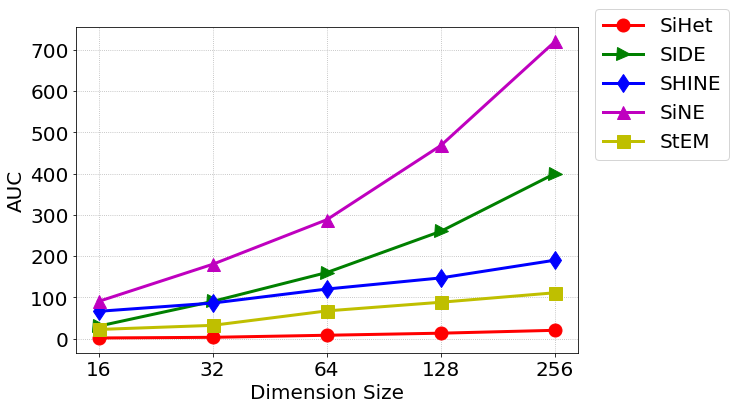

In [ ]:

import matplotlib.pyplot as plt


fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))#figsize=(10, 4)
fig.subplots_adjust(hspace=0.1, wspace=0.3)
ax1.grid(b=True, linestyle=':')


x_values= [1, 2, 3, 4 ,5]
my_xticks = ['16', '32',  '64', '128', '256' ]


#y_values=[ 0.7, 0.8, 0.9, 1.0]
#my_yticks=[ '0.7', '0.8', '0.9', '1.0']

sighet=[1.4, 3, 8,  13,  20]
side=[ 30, 90, 160, 260, 400]
shine=[ 66, 86, 120, 147, 190]
sine=[90, 180, 288, 468  , 720]
stem=[22, 32, 67, 88  , 111]

ax1.plot(x_values, sighet,'r-o',lw=3, markersize=13, label='SiHet')
ax1.plot(x_values, side,'g->',lw=3, markersize=13, label='SIDE')
ax1.plot(x_values, shine,'b-d',lw=3, markersize=13,label='SHINE' )
ax1.plot(x_values, sine,'m-^',lw=3, markersize=13,label='SiNE' )
ax1.plot(x_values, stem,'y-s',lw=3, markersize=13,label='StEM' )


#ax1.set_title('Cora' , fontsize=25)
ax1.set_ylabel('AUC', fontsize=20)
ax1.set_xlabel('Dimension Size', fontsize=20)

ax1.set_xticks(x_values)
ax1.set_xticklabels(my_xticks, fontsize=20)

#ax1.set_yticks(y_values)
#ax1.set_yticklabels(my_yticks, fontsize=20)
ax1.tick_params(axis='both',labelsize=20)


handles, labels = ax1.get_legend_handles_labels()
fig.legend( handles, labels, loc='upper right' ,bbox_to_anchor=(1.14, 0.95) ,ncol=1, fontsize=20) #bbox_to_anchor=(0.5, 0.99)
#fig.tight_layout()
#plt.savefig('./charts/Weibo-link-f1.pdf.pdf')

#plt.title('Performance of methods in event-to-user recommendation')
plt.savefig('effi.pdf',  bbox_inches='tight',dpi=100)

plt.show()


In [ ]:
eval_df.to_csv("/content/drive/My Drive/Data-Science_Lab/4_Evaluate/Evaluation_Report.csv")

Effect of Epoch on AUC

In [ ]:
epoch_list = eval_df[(eval_df["Hidden_layer_1_units"] == 32) & (eval_df["Hidden_layer_2_units"] == 16) & (eval_df["Learning_Rate"] == 0.01)]["Epoch"]
test_roc_list = eval_df[(eval_df["Hidden_layer_1_units"] == 32) & (eval_df["Hidden_layer_2_units"] == 16) & (eval_df["Learning_Rate"] == 0.01)]["Test_Roc"]
val_roc_list = eval_df[(eval_df["Hidden_layer_1_units"] == 32) & (eval_df["Hidden_layer_2_units"] == 16) & (eval_df["Learning_Rate"] == 0.01)]["Val_Roc"]


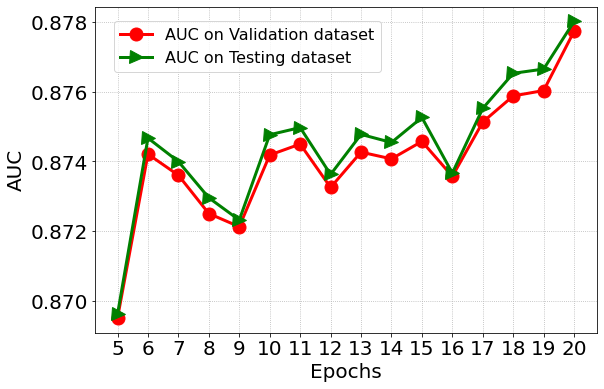

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))#figsize=(10, 4)
fig.subplots_adjust(hspace=0.1, wspace=0.3)
ax1.grid(b=True, linestyle=':')


x_values= range(16)
my_xticks = epoch_list


#y_values=[ 0.7, 0.8, 0.9, 1.0]
#my_yticks=[ '0.7', '0.8', '0.9', '1.0']

sighet=val_roc_list
side=test_roc_list
# shine=[ 66, 86, 120, 147, 190]
# sine=[90, 180, 288, 468  , 720]
# stem=[22, 32, 67, 88  , 111]

ax1.plot(x_values, sighet,'r-o',lw=3, markersize=13, label='AUC on Validation dataset')
ax1.plot(x_values, side,'g->',lw=3, markersize=13, label='AUC on Testing dataset')
# ax1.plot(x_values, shine,'b-d',lw=3, markersize=13,label='SHINE' )
# ax1.plot(x_values, sine,'m-^',lw=3, markersize=13,label='SiNE' )
# ax1.plot(x_values, stem,'y-s',lw=3, markersize=13,label='StEM' )


#ax1.set_title('Cora' , fontsize=25)
ax1.set_ylabel('AUC', fontsize=20)
ax1.set_xlabel('Epochs', fontsize=20)

ax1.set_xticks(x_values)
ax1.set_xticklabels(my_xticks, fontsize=20)

#ax1.set_yticks(y_values)
#ax1.set_yticklabels(my_yticks, fontsize=20)
ax1.tick_params(axis='both',labelsize=20)


handles, labels = ax1.get_legend_handles_labels()
fig.legend( handles, labels, loc='upper right' ,bbox_to_anchor=(0.60, 0.87) ,ncol=1, fontsize=16) #bbox_to_anchor=(0.5, 0.99)
#fig.tight_layout()
#plt.savefig('./charts/Weibo-link-f1.pdf.pdf')

#plt.title('Performance of methods in event-to-user recommendation')
plt.savefig('effi.pdf',  bbox_inches='tight',dpi=100)

plt.show()


In [ ]:
eval_df

,Epoch,Hidden_layer_1_units,Hidden_layer_2_units,Learning_Rate,Training_Loss,Val_Roc,Val_Ap,Test_Roc,Test_Ap
0,5,256,64,0.001,0.691981,0.876480,0.863446,0.877023,0.865210
1,5,256,32,0.001,0.692862,0.875836,0.862891,0.876316,0.864617
2,5,256,16,0.001,0.693054,0.874151,0.861518,0.874253,0.862973
3,5,256,8,0.001,0.693147,0.869273,0.855928,0.869792,0.857768
4,5,128,64,0.001,0.693147,0.869273,0.855928,0.869792,0.857768
...,...,...,...,...,...,...,...,...,...
763,20,64,8,0.100,0.582161,0.831270,0.840560,0.828763,0.840102
764,20,32,64,0.100,0.694961,0.500000,0.500000,0.500000,0.500000
765,20,32,32,0.100,0.696107,0.500000,0.500000,0.500000,0.500000
766,20,32,16,0.100,0.693621,0.500000,0.500000,0.500000,0.500000


Effect of Hidden Layer on AUC

In [ ]:
h1_unit_list = eval_df[(eval_df["Epoch"] == 10) & (eval_df["Hidden_layer_2_units"] == 16) & (eval_df["Learning_Rate"] == 0.01)]["Hidden_layer_1_units"]
test_roc_list = eval_df[(eval_df["Epoch"] == 10) & (eval_df["Hidden_layer_2_units"] == 16) & (eval_df["Learning_Rate"] == 0.01)]["Test_Roc"]
val_roc_list = eval_df[(eval_df["Epoch"] == 10) & (eval_df["Hidden_layer_2_units"] == 16) & (eval_df["Learning_Rate"] == 0.01)]["Val_Roc"]


In [ ]:
h1_unit_list[::-1]

334     32
330     64
326    128
322    256
Name: Hidden_layer_1_units, dtype: object

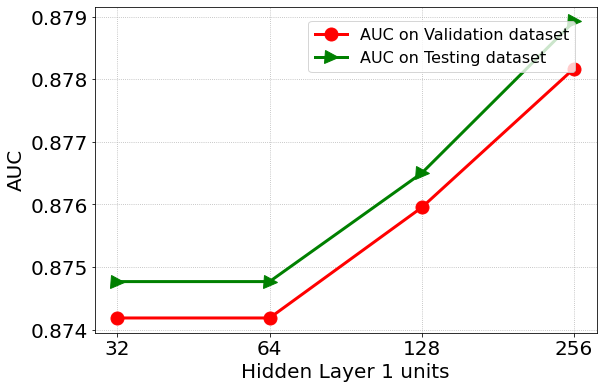

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))#figsize=(10, 4)
fig.subplots_adjust(hspace=0.1, wspace=0.3)
ax1.grid(b=True, linestyle=':')


x_values= range(4)
my_xticks = h1_unit_list[::-1]


#y_values=[ 0.7, 0.8, 0.9, 1.0]
#my_yticks=[ '0.7', '0.8', '0.9', '1.0']

sighet=val_roc_list[::-1]
side=test_roc_list[::-1]
# shine=[ 66, 86, 120, 147, 190]
# sine=[90, 180, 288, 468  , 720]
# stem=[22, 32, 67, 88  , 111]

ax1.plot(x_values, sighet,'r-o',lw=3, markersize=13, label='AUC on Validation dataset')
ax1.plot(x_values, side,'g->',lw=3, markersize=13, label='AUC on Testing dataset')
# ax1.plot(x_values, shine,'b-d',lw=3, markersize=13,label='SHINE' )
# ax1.plot(x_values, sine,'m-^',lw=3, markersize=13,label='SiNE' )
# ax1.plot(x_values, stem,'y-s',lw=3, markersize=13,label='StEM' )


#ax1.set_title('Cora' , fontsize=25)
ax1.set_ylabel('AUC', fontsize=20)
ax1.set_xlabel('Hidden Layer 1 units', fontsize=20)

ax1.set_xticks(x_values)
ax1.set_xticklabels(my_xticks, fontsize=20)

#ax1.set_yticks(y_values)
#ax1.set_yticklabels(my_yticks, fontsize=20)
ax1.tick_params(axis='both',labelsize=20)


handles, labels = ax1.get_legend_handles_labels()
fig.legend( handles, labels, loc='upper right' ,bbox_to_anchor=(0.90, 0.87) ,ncol=1, fontsize=16) #bbox_to_anchor=(0.5, 0.99)
#fig.tight_layout()
#plt.savefig('./charts/Weibo-link-f1.pdf.pdf')

#plt.title('Performance of methods in event-to-user recommendation')
plt.savefig('effi.pdf',  bbox_inches='tight',dpi=100)

plt.show()


In [ ]:
h2_unit_list = eval_df[(eval_df["Epoch"] == 10) & (eval_df["Hidden_layer_1_units"] == 32) & (eval_df["Learning_Rate"] == 0.01)]["Hidden_layer_2_units"]
test_roc_list = eval_df[(eval_df["Epoch"] == 10) & (eval_df["Hidden_layer_1_units"] == 32) & (eval_df["Learning_Rate"] == 0.01)]["Test_Roc"]
val_roc_list = eval_df[(eval_df["Epoch"] == 10) & (eval_df["Hidden_layer_1_units"] == 32) & (eval_df["Learning_Rate"] == 0.01)]["Val_Roc"]


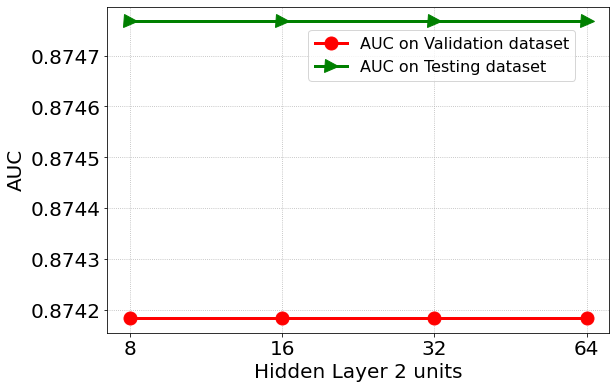

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))#figsize=(10, 4)
fig.subplots_adjust(hspace=0.1, wspace=0.3)
ax1.grid(b=True, linestyle=':')


x_values= range(4)
my_xticks = h2_unit_list[::-1]


#y_values=[ 0.7, 0.8, 0.9, 1.0]
#my_yticks=[ '0.7', '0.8', '0.9', '1.0']

sighet=val_roc_list[::-1]
side=test_roc_list[::-1]
# shine=[ 66, 86, 120, 147, 190]
# sine=[90, 180, 288, 468  , 720]
# stem=[22, 32, 67, 88  , 111]

ax1.plot(x_values, sighet,'r-o',lw=3, markersize=13, label='AUC on Validation dataset')
ax1.plot(x_values, side,'g->',lw=3, markersize=13, label='AUC on Testing dataset')
# ax1.plot(x_values, shine,'b-d',lw=3, markersize=13,label='SHINE' )
# ax1.plot(x_values, sine,'m-^',lw=3, markersize=13,label='SiNE' )
# ax1.plot(x_values, stem,'y-s',lw=3, markersize=13,label='StEM' )


#ax1.set_title('Cora' , fontsize=25)
ax1.set_ylabel('AUC', fontsize=20)
ax1.set_xlabel('Hidden Layer 2 units', fontsize=20)

ax1.set_xticks(x_values)
ax1.set_xticklabels(my_xticks, fontsize=20)

#ax1.set_yticks(y_values)
#ax1.set_yticklabels(my_yticks, fontsize=20)
ax1.tick_params(axis='both',labelsize=20)


handles, labels = ax1.get_legend_handles_labels()
fig.legend( handles, labels, loc='upper right' ,bbox_to_anchor=(0.90, 0.85) ,ncol=1, fontsize=16) #bbox_to_anchor=(0.5, 0.99)
#fig.tight_layout()
#plt.savefig('./charts/Weibo-link-f1.pdf.pdf')

#plt.title('Performance of methods in event-to-user recommendation')
plt.savefig('effi.pdf',  bbox_inches='tight',dpi=100)

plt.show()


In [ ]:
learning_rate_list = eval_df[(eval_df["Epoch"] == 10) & (eval_df["Hidden_layer_1_units"] == 32) & (eval_df["Hidden_layer_2_units"] == 16)]["Learning_Rate"]
test_roc_list = eval_df[(eval_df["Epoch"] == 10) & (eval_df["Hidden_layer_1_units"] == 32) & (eval_df["Hidden_layer_2_units"] == 16)]["Test_Roc"]
val_roc_list = eval_df[(eval_df["Epoch"] == 10) & (eval_df["Hidden_layer_1_units"] == 32) & (eval_df["Hidden_layer_2_units"] == 16)]["Val_Roc"]


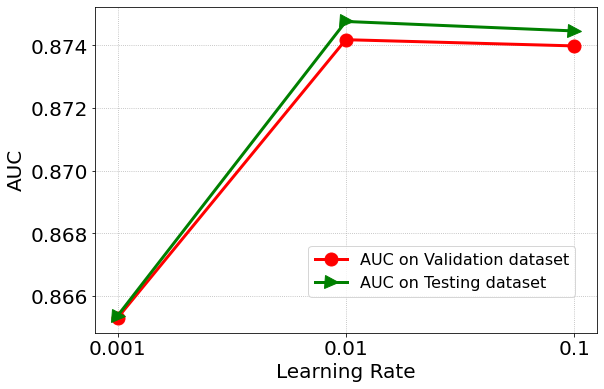

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))#figsize=(10, 4)
fig.subplots_adjust(hspace=0.1, wspace=0.3)
ax1.grid(b=True, linestyle=':')


x_values= range(3)
my_xticks = learning_rate_list


#y_values=[ 0.7, 0.8, 0.9, 1.0]
#my_yticks=[ '0.7', '0.8', '0.9', '1.0']

sighet=val_roc_list
side=test_roc_list
# shine=[ 66, 86, 120, 147, 190]
# sine=[90, 180, 288, 468  , 720]
# stem=[22, 32, 67, 88  , 111]

ax1.plot(x_values, sighet,'r-o',lw=3, markersize=13, label='AUC on Validation dataset')
ax1.plot(x_values, side,'g->',lw=3, markersize=13, label='AUC on Testing dataset')
# ax1.plot(x_values, shine,'b-d',lw=3, markersize=13,label='SHINE' )
# ax1.plot(x_values, sine,'m-^',lw=3, markersize=13,label='SiNE' )
# ax1.plot(x_values, stem,'y-s',lw=3, markersize=13,label='StEM' )


#ax1.set_title('Cora' , fontsize=25)
ax1.set_ylabel('AUC', fontsize=20)
ax1.set_xlabel('Learning Rate', fontsize=20)

ax1.set_xticks(x_values)
ax1.set_xticklabels(my_xticks, fontsize=20)

#ax1.set_yticks(y_values)
#ax1.set_yticklabels(my_yticks, fontsize=20)
ax1.tick_params(axis='both',labelsize=20)


handles, labels = ax1.get_legend_handles_labels()
fig.legend( handles, labels, loc='upper right' ,bbox_to_anchor=(0.90, 0.35) ,ncol=1, fontsize=16) #bbox_to_anchor=(0.5, 0.99)
#fig.tight_layout()
#plt.savefig('./charts/Weibo-link-f1.pdf.pdf')

#plt.title('Performance of methods in event-to-user recommendation')
plt.savefig('effi.pdf',  bbox_inches='tight',dpi=100)

plt.show()
